In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
!unzip ba.zip
!unzip bhA.zip
!unzip ka.zip
!unzip ni.zip
!unzip tA.zip

Archive:  ba.zip
  inflating: ba/Train/19_ba_36_12.mfcc  
  inflating: ba/Train/19_ba_35_13.mfcc  
  inflating: ba/Train/19_ba_25_2.mfcc  
  inflating: ba/Train/19_ba_217_11.mfcc  
  inflating: ba/Train/19_ba_207_5.mfcc  
  inflating: ba/Train/19_ba_177_1.mfcc  
  inflating: ba/Train/19_ba_14_2.mfcc  
  inflating: ba/Train/19_ba_101_10.mfcc  
  inflating: ba/Train/18_ba_98_6.mfcc  
  inflating: ba/Train/18_ba_89_3.mfcc  
  inflating: ba/Train/18_ba_79_8.mfcc  
  inflating: ba/Train/18_ba_77_2.mfcc  
  inflating: ba/Train/18_ba_68_8.mfcc  
  inflating: ba/Train/18_ba_5_7.mfcc  
  inflating: ba/Train/18_ba_47_7.mfcc  
  inflating: ba/Train/18_ba_46_11.mfcc  
  inflating: ba/Train/18_ba_42_6.mfcc  
  inflating: ba/Train/18_ba_40_6.mfcc  
  inflating: ba/Train/18_ba_31_15.mfcc  
  inflating: ba/Train/18_ba_25_2.mfcc  
  inflating: ba/Train/18_ba_23_3.mfcc  
  inflating: ba/Train/18_ba_1_12.mfcc  
  inflating: ba/Train/18_ba_179_6.mfcc  
  inflating: ba/Train/18_ba_176_12.mfcc  
  inflating

In [ ]:
def Load_Data(type, dtype):
  directory_path = '/content/'+type+'/'+dtype+'/'
  all_mfcc_data = []
  for filename in os.listdir(directory_path):
      d = []
      if filename.endswith('.mfcc'):
          file_path = os.path.join(directory_path, filename)
          with open(file_path, 'r') as f:
              for line in f:
                  mfcc_features = list(map(float, line.strip().split()))
                  d.append(mfcc_features)
      all_mfcc_data.append(d)


  return all_mfcc_data

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
classes = ['ba','bhA','ka','ni','tA']
# Load Train Data
for i in range(len(classes)):
  data = Load_Data(classes[i],'Train')
  for d in data:
    x_train.append(d)
    y_train.append(i)

# Load Test Data
for i in range(len(classes)):
  data = Load_Data(classes[i],'Test')
  for d in data:
    x_test.append(d)
    y_test.append(i)

In [ ]:
x_train_tensor = pad_sequence([torch.tensor(x) for x in x_train], batch_first=True, padding_value=0.0)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = pad_sequence([torch.tensor(x) for x in x_test], batch_first=True, padding_value=0.0)

y_test_tensor = torch.tensor(y_test, dtype=torch.long)
print(x_train_tensor.shape)
print(y_train_tensor)
print(x_test_tensor.shape)
print(y_test_tensor.shape)
# Create datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


# Create datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

torch.Size([1464, 79, 39])
tensor([0, 0, 0,  ..., 4, 4, 4])
torch.Size([366, 73, 39])
torch.Size([366])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define the RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)

        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

In [ ]:
# Hyperparameters
input_size = 39  # Number of MFCC features
hidden_size = 128  # Number of neurons in each hidden layer
num_layers = 20  # Number of RNN/LSTM layers
num_classes = 5  # Number of CV segment classes
learning_rate = 0.0001
batch_size = 16
num_epochs = 50

RNN training

In [ ]:
# Initialize models
rnn_model = RNNModel(input_size, hidden_size, num_layers, num_classes)

# Los and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_rnn = optim.RMSprop(rnn_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for data, labels in train_loader:
        outputs_rnn = rnn_model(data)
        loss_rnn = criterion(outputs_rnn, labels)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_rnn.item():.4f}')
        # Backpropagation and optimization
        loss_rnn.backward()
        optimizer_rnn.step()
        optimizer_rnn.zero_grad()


Epoch [1/50], Loss: 1.5970
Epoch [1/50], Loss: 1.6556
Epoch [1/50], Loss: 1.5957
Epoch [1/50], Loss: 1.5218
Epoch [1/50], Loss: 1.5450
Epoch [1/50], Loss: 1.6288
Epoch [1/50], Loss: 1.5816
Epoch [1/50], Loss: 1.6059
Epoch [1/50], Loss: 1.5589
Epoch [1/50], Loss: 1.5024
Epoch [1/50], Loss: 1.5352
Epoch [1/50], Loss: 1.5854
Epoch [1/50], Loss: 1.4866
Epoch [1/50], Loss: 1.5564
Epoch [1/50], Loss: 1.6810
Epoch [1/50], Loss: 1.5303
Epoch [1/50], Loss: 1.5607
Epoch [1/50], Loss: 1.5828
Epoch [1/50], Loss: 1.5328
Epoch [1/50], Loss: 1.6788
Epoch [1/50], Loss: 1.5685
Epoch [1/50], Loss: 1.6212
Epoch [1/50], Loss: 1.6271
Epoch [1/50], Loss: 1.5632
Epoch [1/50], Loss: 1.5698
Epoch [1/50], Loss: 1.6199
Epoch [1/50], Loss: 1.5756
Epoch [1/50], Loss: 1.5495
Epoch [1/50], Loss: 1.5349
Epoch [1/50], Loss: 1.5339
Epoch [1/50], Loss: 1.6630
Epoch [1/50], Loss: 1.5827
Epoch [1/50], Loss: 1.5401
Epoch [1/50], Loss: 1.5263
Epoch [1/50], Loss: 1.5971
Epoch [1/50], Loss: 1.5413
Epoch [1/50], Loss: 1.5707
E

In [ ]:
#testing loop
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        outputs_rnn = rnn_model(data)
        _, predicted = torch.max(outputs_rnn, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuarcy = correct/total
print(accuarcy)

0.5273224043715847


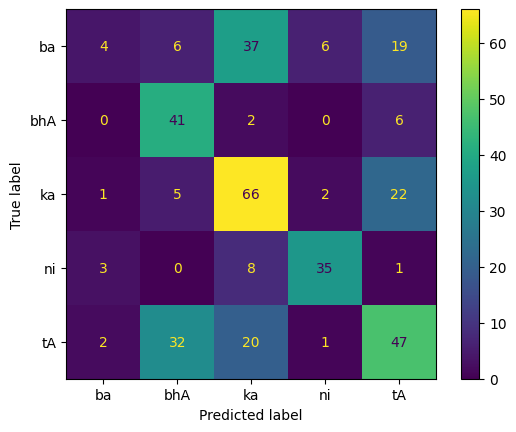

In [ ]:
#confusion matrix
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        outputs = rnn_model(data)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

LSTM TRAINING AND TESTING

In [ ]:
# Hyperparameters
input_size = 39  # Number of MFCC features
hidden_size = 128  # Number of neurons in each hidden layer
num_layers = 2  # Number of RNN/LSTM layers
num_classes = 5  # Number of CV segment classes
learning_rate = 0.001
batch_size = 16
num_epochs = 50

In [ ]:
# Initialize models
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

# Los and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for data, labels in train_loader:
        outputs_lstm = lstm_model(data)
        loss_lstm = criterion(outputs_lstm, labels)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_lstm.item():.4f}')
        # Backpropagation and optimization
        loss_lstm.backward()
        optimizer_lstm.step()
        optimizer_lstm.zero_grad()


Epoch [1/50], Loss: 1.5997
Epoch [1/50], Loss: 1.6013
Epoch [1/50], Loss: 1.5950
Epoch [1/50], Loss: 1.5857
Epoch [1/50], Loss: 1.5892
Epoch [1/50], Loss: 1.5840
Epoch [1/50], Loss: 1.5917
Epoch [1/50], Loss: 1.5729
Epoch [1/50], Loss: 1.5388
Epoch [1/50], Loss: 1.6213
Epoch [1/50], Loss: 1.5509
Epoch [1/50], Loss: 1.6059
Epoch [1/50], Loss: 1.5741
Epoch [1/50], Loss: 1.5302
Epoch [1/50], Loss: 1.6437
Epoch [1/50], Loss: 1.5905
Epoch [1/50], Loss: 1.5374
Epoch [1/50], Loss: 1.6547
Epoch [1/50], Loss: 1.5176
Epoch [1/50], Loss: 1.5887
Epoch [1/50], Loss: 1.6031
Epoch [1/50], Loss: 1.5266
Epoch [1/50], Loss: 1.5895
Epoch [1/50], Loss: 1.5413
Epoch [1/50], Loss: 1.5028
Epoch [1/50], Loss: 1.5363
Epoch [1/50], Loss: 1.5781
Epoch [1/50], Loss: 1.5732
Epoch [1/50], Loss: 1.5340
Epoch [1/50], Loss: 1.6045
Epoch [1/50], Loss: 1.5606
Epoch [1/50], Loss: 1.6548
Epoch [1/50], Loss: 1.5764
Epoch [1/50], Loss: 1.5234
Epoch [1/50], Loss: 1.5715
Epoch [1/50], Loss: 1.5302
Epoch [1/50], Loss: 1.4977
E

In [ ]:
#testing loop
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        outputs_lstm = lstm_model(data)
        _, predicted = torch.max(outputs_lstm, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct/total
print(accuracy)

0.8661202185792349


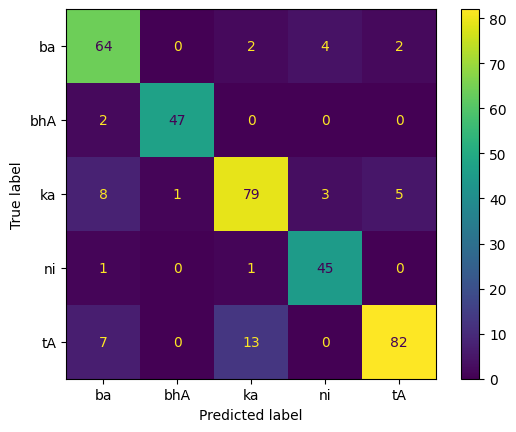

In [ ]:
#confusion matrix
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        outputs = lstm_model(data)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()